In [37]:
import numpy as np
import pandas as pd 
import os
import re
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import string
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import os
import nltk
import spacy
from spacy.util import compounding
from spacy.util import minibatch
from sklearn.model_selection import train_test_split

In [30]:
# url = f"https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/re_dataset.csv"
# url = f"https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/new_kamusalay.csv"
url = f"https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/abusive.csv"
# url = f"https://github.com/rifkisrg/text-mining-project-akhir/raw/70f8fb1c4a9a29cd86a32e15567777506e84ea23/stopwordbahasa.csv"
!wget --no-cache --backups=1 {url}

--2022-04-09 02:33:59--  https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/abusive.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 975 [text/plain]
Failed to rename abusive.csv to abusive.csv.1: (2) No such file or directory
Saving to: ‘abusive.csv’

abusive.csv         100%[===================>]     975  --.-KB/s    in 0s      

2022-04-09 02:33:59 (101 MB/s) - ‘abusive.csv’ saved [975/975]



In [31]:
import pandas as pd
import numpy as np

In [32]:
data = pd.read_csv('/content/re_dataset.csv', encoding='latin-1', engine ='python')

In [33]:
alay_dict = pd.read_csv('new_kamusalay.csv', names = ['original', 'replacement'], encoding='latin-1')
abusive_dict = pd.read_csv('abusive.csv', encoding='latin-1')
stopword_dict = pd.read_csv('stopwordbahasa.csv', names = ['stopword'], encoding='latin-1')

In [35]:
abusive_dict.head()

,ABUSIVE
0,alay
1,ampas
2,buta
3,keparat
4,anjing


In [36]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\\+n', ' ', text)
    text = re.sub('\n'," ",text) # Remove every '\n'
    
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('RT',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('USER', ' ', text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(':', ' ', text)
    text = re.sub(';', ' ', text)
    text = re.sub('\\+n', ' ', text)
    text = re.sub('\n'," ",text) # Remove every '\n'
    text = re.sub('\\+', ' ', text)
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join(['' if word in stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

# def stemming(text):
#     return stemmer.stem(text)

def remove_emoticon_byte(text):
    text = text.replace("\\", " ")
    text = re.sub('x..', ' ', text)
    text = re.sub(' n ', ' ', text)
    text = re.sub('\\+', ' ', text)
    text = re.sub('  +', ' ', text)
    return text

def remove_early_space(text):
    if text[0] == ' ':
        return text[1:]
    else:
        return text

In [38]:
# Test cleaning

In [41]:
print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa!!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
# print("stemming: ", stemming("Perekonomian Indonesia sedang dalam pertumbuhan yang membanggakan"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))
print("remove_stopword: ", remove_stopword("ada hehe adalah huhu yang hehe"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe apa kabs hehe
normalize_alay:  amin adik habis
remove_stopword:  hehe huhu hehe


In [150]:
# Source: https://www.kaggle.com/code/corneliustantius/indonesia-hatespeech-recognition-main-notebook
def preprocess1(text):
#     text = lowercase(text) # 1
#     text = remove_nonaplhanumeric(text) # 2
    text = remove_unnecessary_char(text) # 2
    text = normalize_alay(text) # 3
    text = remove_unnecessary_char(text)
#     text = stemming(text) # 4
    text = remove_stopword(text) # 5
    # text = lowercase(text)
    text = remove_emoticon_byte(text)
    # text = remove_early_space(text)
    text = remove_nonaplhanumeric(text)
    text = text.replace('url', '')
    text = text.replace('amp')
    return text

def preprocess(text):
#     text = lowercase(text) # 1
#     text = remove_nonaplhanumeric(text) # 2
    text = remove_unnecessary_char(text) # 2
    text = normalize_alay(text) # 3
    text = remove_unnecessary_char(text)
#     text = stemming(text) # 4
#     text = remove_stopword(text) # 5
    text = remove_emoticon_byte(text)
    text = remove_early_space(text)
    text = remove_nonaplhanumeric(text)
    text = lowercase(text)
    text = remove_stopword(text)
    text = text.replace('url', '')
    text = text.replace('amp', '')
    return text

# def classify(hs):
#     retval = ""
#     if int(hs) == 1:
#         retval = 'positive'
#     else:
#         retval = 'negative'
#     return retval

In [151]:
data['text'] = data['Tweet'].apply(preprocess)
data[['text', 'HS']].head(10)

,text,HS
0,cowok berusaha melacak perhatian gue lantas re...,1
1,telat tau elu edan sarap gue bergaul ciga ifla...,0
2,41 kadang berfikir percaya tuhan jatuh berkali...,0
3,nku tau matamu sipit diliat,0
4,kaum cebong kafir dongoknya dungu hahahah,1
5,ya bani taplak kawan kawan,1
6,deklarasi pilihan kepala daerah 2018 aman anti...,0
7,gue selesai re watch aldnoah zero kret endingn...,0
8,admin belanja po terbaik nak makan ais kepal m...,0
9,enak ngewe,0


In [152]:
from sklearn.model_selection import train_test_split
X = data['text']
y = data['HS']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

In [153]:
train = pd.DataFrame()
train['text'] = X_train
train['HS'] = y_train 

test = pd.DataFrame()
test['text'] = X_test
test['HS'] = y_test

In [154]:
train.to_csv('train_preprocessed.csv')
test.to_csv('test_preprocessed.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


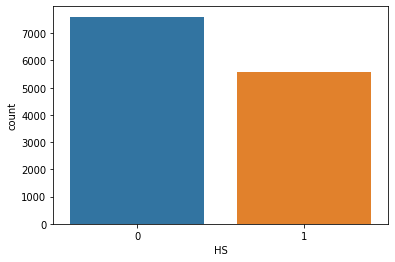

In [155]:
sns.countplot(data.HS)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


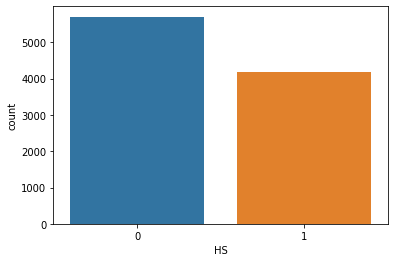

In [156]:
sns.countplot(train.HS)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


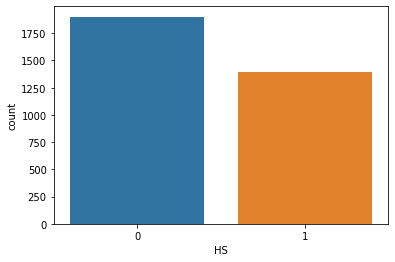

In [157]:
sns.countplot(test.HS)

In [158]:
def s(text):
    return text.split()

positive_text = train[train['HS']==0].text.apply(s)
negative_text = train[train['HS']==1].text.apply(s)

In [159]:
positive_text

7345     [tkp, ditemukan, dokumen, disket, email, menye...
634      [cagub, jabar, bicara, toleransi, muzakarah, i...
12133    [iya, situ, cina, langsung, kasih, palestina, ...
6646                                          [bom, diiah]
845      [soeha, o, komunis, menguasai, negeri, agama, ...
                               ...                        
3831     [ketua, pan, maju, calon, presiden, republik, ...
10542    [alah, gaduh, orang, orang, surat, pemberitahu...
12549                                          [hah, nete]
7039     [oia, gays, semalam, admin, ml, video, crot, n...
5329     [lu, jerawatan, cakap, lu, gendut, cantik, lu,...
Name: text, Length: 5706, dtype: object

In [160]:
top = Counter([item for sublist in positive_text for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,orang,612
1,gue,493
2,presiden,483
3,ya,457
4,agama,340
5,indonesia,329
6,asing,320
7,islam,285
8,n,281
9,a,265


In [161]:
top = Counter([item for sublist in negative_text for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,cebong,399
2,orang,385
3,ya,346
4,indonesia,300
5,cina,277
6,sih,272
7,islam,270
8,presiden,263
9,nya,247
10,ahok,234


In [162]:
' '.join([' '.join(x) for x in positive_text])

'tkp ditemukan dokumen disket email menyebut keterlibatan tokoh nhendardi ale idya siregar sofyan wanandi surya paloh yayasan prasetya mulya perkumpulan konglomerat tionghoa cagub jabar bicara toleransi muzakarah icmi jabar iya situ cina langsung kasih palestina negara negara arab dibebankan palestina palestina dicekok utang fokus utang ngga lihat cina negatif bom diiah soeha o komunis menguasai negeri agama sepe i skrng so far tantangan nya sih ya sehat ya bolak mengurus dokumen tersiapkan matang pengalaman serunya tki kayak gue susah payah antri macet dll yg orang orang mempolitisasi isu isu islam nusantara bhkn bilang sesat kafir dll isu isu sepe i dipolitisasi kepentingan politik klo perbedaan pendapat ya sila mengaduk aduk jawa kayak dki makan pandai belajar pilihan kepala daerah jaka a kecacatan lgbt ruang kononnya kebebasan hak hedonisme dirancakkan radiohead intinya cina dipandang negatif disayangkan skrg cina cina indonesia kena imbas masyarakat sensitif cina pki pki kanye and

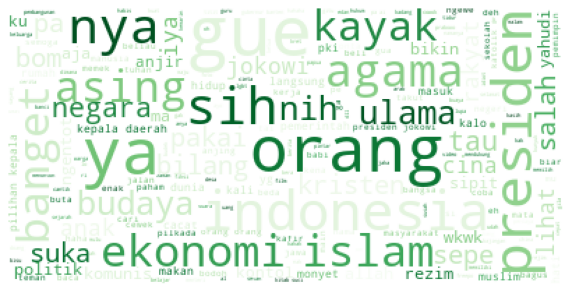

In [163]:
# pos_mask = np.array(Image.open('../input/masksforwordclouds/twitter_mask.png'))
wordcloud = WordCloud(background_color='white', max_font_size=50, max_words=200, colormap='Greens').generate(' '.join([' '.join(x) for x in positive_text]))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

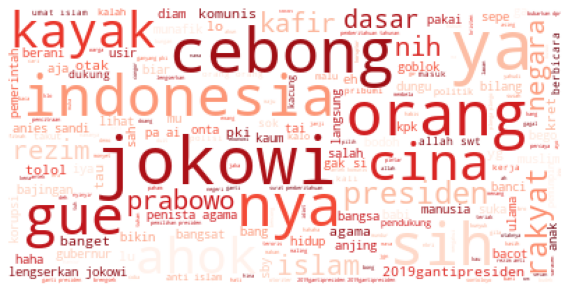

In [164]:
# pos_mask = np.array(Image.open('../input/masksforwordclouds/twitter_mask.png'))
wordcloud = WordCloud(background_color='white', max_font_size=50, max_words=200, colormap='Reds').generate(' '.join([' '.join(x) for x in negative_text]))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [165]:
#NLP tools
import re
import nltk
# nltk.download('stopwords')
# nltk.download('rslp')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier


In [166]:
# Logistic Regression
model = Pipeline([
    ('vectorizer', CountVectorizer()),   
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression())
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Accuracy: 83.21%
F1 Score: 0.788689
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1902
           1       0.84      0.74      0.79      1391

    accuracy                           0.83      3293
   macro avg       0.83      0.82      0.82      3293
weighted avg       0.83      0.83      0.83      3293



In [167]:
# MultinomialNB
model = Pipeline([
    ('vectorizer', CountVectorizer()),   
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Accuracy: 83.15%
F1 Score: 0.788732
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1902
           1       0.84      0.74      0.79      1391

    accuracy                           0.83      3293
   macro avg       0.83      0.82      0.82      3293
weighted avg       0.83      0.83      0.83      3293



In [168]:
# Random Forest Classifier
model = Pipeline([
    ('vectorizer', CountVectorizer()),   
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier())
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Accuracy: 83.94%
F1 Score: 0.805443
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1902
           1       0.82      0.79      0.81      1391

    accuracy                           0.84      3293
   macro avg       0.84      0.83      0.83      3293
weighted avg       0.84      0.84      0.84      3293



In [169]:
# SGD
model = Pipeline([
    ('vectorizer', CountVectorizer()),   
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                           alpha=0.0005, random_state=0,
                           max_iter=50, tol=None))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Accuracy: 81.54%
F1 Score: 0.751227
              precision    recall  f1-score   support

           0       0.79      0.93      0.85      1902
           1       0.87      0.66      0.75      1391

    accuracy                           0.82      3293
   macro avg       0.83      0.79      0.80      3293
weighted avg       0.82      0.82      0.81      3293

